In [1]:
# CAPTURE/EXTRACT STATIC FRAMES FROM VIDEO

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

# print(cv2.__version__)
# vidcap = cv2.VideoCapture('challenge-Copy1.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# while success:
#   cv2.imwrite("syc_frame%d.jpg" % count, image)     # save frame as JPEG file
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1

In [2]:
# CANNY EDGE DETECTION FUNCTION
def my_ced(jpg_image):

    # Read in the image and convert to hls
    image = mpimg.imread(jpg_image)
    img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
   # White color mask
    Wlower = np.uint8([  0, 200,   0])
    Wupper = np.uint8([255, 255, 255])
    White_Mask = cv2.inRange(img_hls, Wlower, Wupper)
    # Yellow color mask
    Ylower = np.uint8([ 0,   0, 100])
    Yupper = np.uint8([ 50, 255, 255])
    Yellow_Mask = cv2.inRange(img_hls, Ylower, Yupper)
    # Combine the mask
    Mask_wy = cv2.bitwise_or(White_Mask, Yellow_Mask)
    HSL_wy = cv2.bitwise_and(image, image, mask = Mask_wy)

    
    # Filter white and yellow

    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(HSL_wy,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 200
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(edges, cmap='Greys_r')

    print('Canny Edge Detection:' + jpg_image)
    plt.show()
    return edges

In [3]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

class my_mpht_so(object):
    def __init__(self, m_parm, b_parm, x1_parm, y1_parm, x2_parm, y2_parm):
        self.m_parm = m_parm
        self.b_parm = b_parm
        self.x1_parm = x1_parm
        self.y1_parm = y1_parm
        self.x2_parm = x2_parm
        self.y2_parm = y2_parm


def my_mpht(jpg_image,mc_in,edges):
    
    # Read in the image
    image = mpimg.imread(jpg_image)
    
    # make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)    
    
    # Define a region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

    # obtain these coordinates using WebPlotDigitizer at https://apps.automeris.io/wpd/
    mask_cords = mc_in

    mask_cords = np.round(mask_cords)
    mask_cords = mask_cords.astype(int)
    mask_cords = tuple(map(tuple,mask_cords))

    # Draw a line with thickness of 4 px
    ic = 1
    while (ic<len(mask_cords)):
        region_select = cv2.line(region_select,mask_cords[ic-1],mask_cords[ic],(255,0,0),4)
        ic = ic+1

    region_select = cv2.line(region_select,mask_cords[-1],mask_cords[0],(255,0,0),4)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255

    # This time we are defining a n sided polygon to mask
    imshape = image.shape
    vertices = np.array([mask_cords], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 2
    min_line_length = 10
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
    m_parm = []
    b_parm = []
    x1_parm = []
    y1_parm = []
    x2_parm = []
    y2_parm = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            m_parm_cur = (y2-y1)/(x2-x1)
            if ((m_parm_cur<-0.05)|(m_parm_cur>0.05)):
                m_parm.append(m_parm_cur)
                b_parm.append(y1-x1*(y2-y1)/(x2-x1))
                x1_parm.append(x1)
                y1_parm.append(y1)
                x2_parm.append(x2)
                y2_parm.append(y2)
            else:
                # Do Nothing
                dummy_var = 1


    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(region_select, cmap='Greys_r')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(combo)

    print('Masking and P-Hough Transform:' + jpg_image)
    plt.show()
    return my_mpht_so(m_parm, b_parm, x1_parm, y1_parm, x2_parm, y2_parm)
    


In [4]:
# FINAL LANE DETECTION LINES WITH TRANSPARENCY

def my_fld(jpg_image,eps_in):
    
    # DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
    # USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
    # ONCE SORTED DETERMINE 
    # > AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
    # > MIN Y FOR EACH OF EACH OF LEFT AND RIGHT LANES AND CORRESPONDING X
    # > using MEAN SLOPES AND and MIN Ys and CORRESPONDING Xs DETERMINE bs in y=mx+b
    # > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) DETERMINE CORRESPONDING X

    # Read in the image
    image = mpimg.imread(jpg_image)
    # make a copy of the image
    ysize = image.shape[0]
    # ysize = ysize-75
    xsize = image.shape[1]
    
    # EPS PARMS
    m_parm = eps_in.m_parm
    b_parm = eps_in.b_parm    
    x1_parm = eps_in.x1_parm
    y1_parm = eps_in.y1_parm
    x2_parm = eps_in.x2_parm
    y2_parm = eps_in.y2_parm
    
    # Capture all (x,y) coordinates for the masked edge lines
    m_parm = np.asarray(m_parm)
    b_parm = np.asarray(b_parm)    
    x1_parm = np.asarray(x1_parm)
    y1_parm = np.asarray(y1_parm)
    x2_parm = np.asarray(x2_parm)
    y2_parm = np.asarray(y2_parm)

    mp_sort = sorted(m_parm)
    b_sort = b_parm[np.argsort(m_parm)]
    x1_sort = x1_parm[np.argsort(m_parm)]
    y1_sort = y1_parm[np.argsort(m_parm)]
    x2_sort = x2_parm[np.argsort(m_parm)]
    y2_sort = y2_parm[np.argsort(m_parm)]

    mp_neg = list(filter(lambda x: x < 0, m_parm)) 
    mp_neg_len = len(mp_neg)

    mp_neg_b = b_sort[0:mp_neg_len]
    mp_neg_x1 = x1_sort[0:mp_neg_len]
    mp_neg_y1 = y1_sort[0:mp_neg_len]
    mp_neg_x2 = x2_sort[0:mp_neg_len]
    mp_neg_y2 = y2_sort[0:mp_neg_len]

    mp_neg_x = np.hstack((mp_neg_x1,mp_neg_x2))
    mp_neg_y = np.hstack((mp_neg_y1,mp_neg_y2))

    mp_pos = list(filter(lambda x: x > 0, m_parm))    
    mp_pos_b = b_sort[(mp_neg_len):]    
    mp_pos_x1 = x1_sort[(mp_neg_len):]
    mp_pos_y1 = y1_sort[(mp_neg_len):]
    mp_pos_x2 = x2_sort[(mp_neg_len):]
    mp_pos_y2 = y2_sort[(mp_neg_len):]

    mp_pos_x = np.hstack((mp_pos_x1,mp_pos_x2))
    mp_pos_y = np.hstack((mp_pos_y1,mp_pos_y2))
    
    min_neg_y = np.min(mp_neg_y)
    min_pos_y = np.min(mp_pos_y)
    # global min-y
    min_gy = np.min([min_neg_y, min_pos_y])
    
    mmp_neg = np.mean(mp_neg)
    bp_neg = np.mean(mp_neg_b)
    
    min_neg_x = int(round((min_gy-bp_neg)/mmp_neg))
    lmn_x1y1 = (min_neg_x,min_gy)

    lmn_x2 = int(round((ysize-bp_neg)/mmp_neg))
    lmn_x2y2 = (lmn_x2,ysize)
    
    mmp_pos = np.mean(mp_pos)
    bp_pos = np.mean(mp_pos_b)
    
    min_pos_x = int(round((min_gy-bp_pos)/mmp_pos))
    lmp_x1y1 = (min_pos_x,min_gy)

    lmp_x2 = int(round((ysize-bp_pos)/mmp_pos))
    lmp_x2y2 = (lmp_x2,ysize)

    lane_select = np.copy(image)
    # Draw a line with thickness of 4 px
    lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),18)
    lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),18)
    
    alpha = 0.4  # Transparency factor.
    lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)
    
    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(lane_select)
    
    print('Final Lane Detection and Transparency:' + jpg_image)
    plt.show()
    
    # SAVING FINAL OUTPUT
    fig_s = plt.figure()
    fig_s.set_size_inches(18.5, 10.5)
    ax_s = plt.gca()
    ax_s.imshow(lane_select)
    plt.axis('off')    
    plt.savefig('fo_'+jpg_image)
    print('Final Output Saved:' + jpg_image)
    

Canny Edge Detection:syc_frame0.jpg


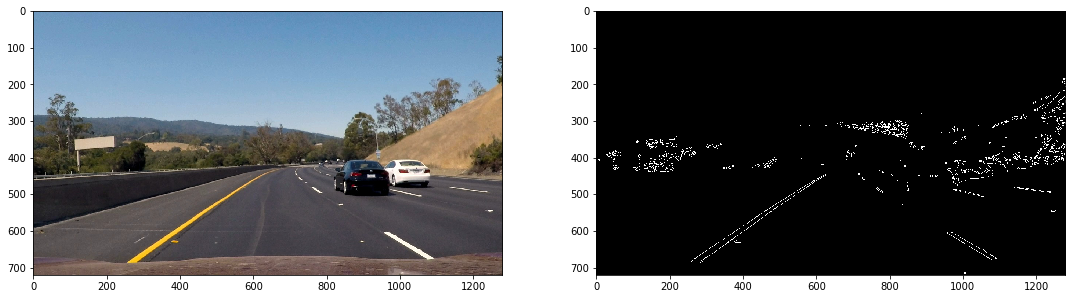

Masking and P-Hough Transform:syc_frame0.jpg


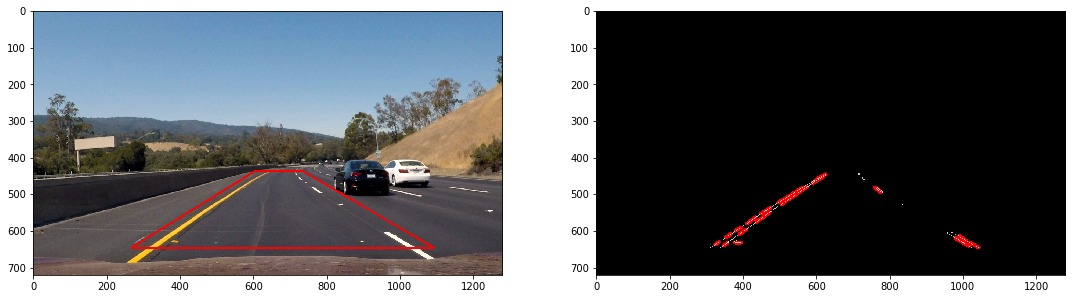

Final Lane Detection and Transparency:syc_frame0.jpg


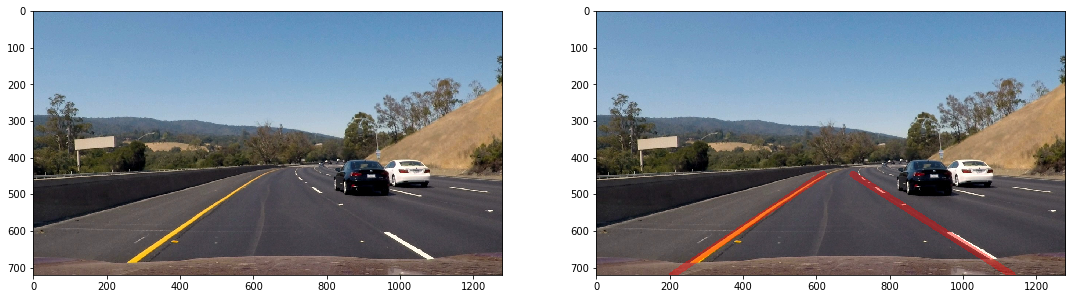

Final Output Saved:syc_frame0.jpg


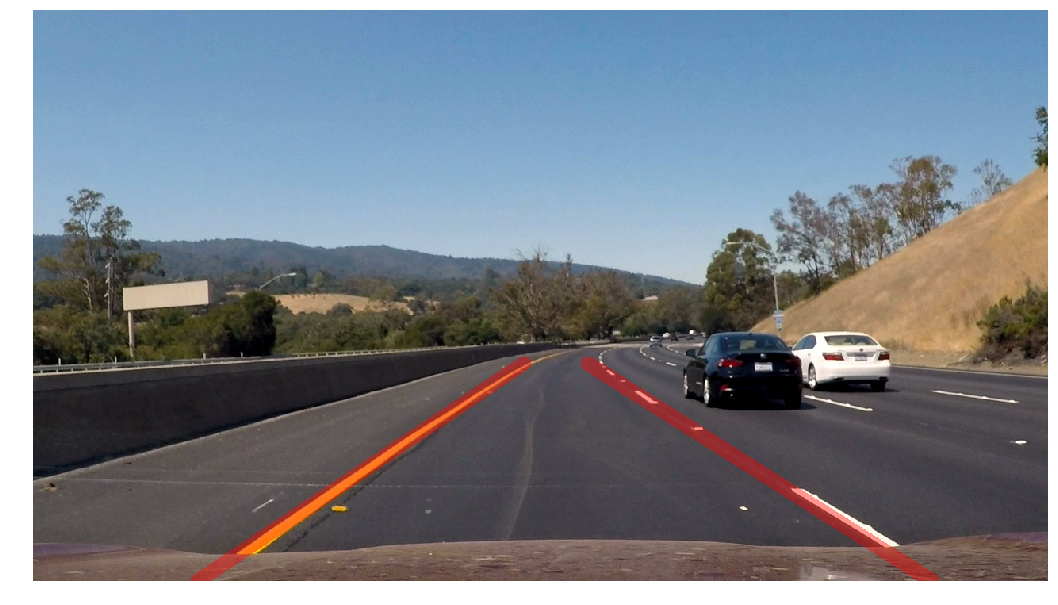

In [5]:
# PIPELINE TO EXECUTE
# > CANNY EDGE DETECTION FUNCTION
# > MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES
# > FINAL LANE DETECTION LINES WITH TRANSPARENCY
# ON EACH INDIVIDUAL STATIC FRAMES CAPTURED FROM THE VIDEO

ic = 0
# max:250
while ((ic<1)):
    
    skip_fs = [111, 145, 146, 148, 178, 183, 219, 223, 249, 250]
    if (ic in set(skip_fs)):
        print('skipping frame:'+str(ic)+'.jpg')
    else:
        # CURRENT STATIC FRAME/IMAGE
        jpg_image = 'syc_frame'+str(ic)+'.jpg'

        # CANNY EDGE DETECTION FUNCTION
        cur_edges = my_ced(jpg_image)

        # Define a region of interest 
        # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

        mc_in = [(267.7272727272727, 645),
                (605.9779614325068, 434.71074380165294),
                (732.6446280991734, 434.71074380165294),
                (1091.0468319559227, 645)]

        # MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES    
        my_mpht_out = my_mpht(jpg_image,mc_in,cur_edges)
        
        # FINAL LANE DETECTION LINES WITH TRANSPARENCY
        my_fld(jpg_image,my_mpht_out)

    ic = ic+1

In [1]:
# # MAKING VIDEO FROM FINAL OUTPUT FRAMES

# fo_syc_frame0 = cv2.imread('fo_syc_frame0.jpg')

# vid_height, vid_width, vid_layers =  fo_syc_frame0.shape

# fourcc = cv2.VideoWriter_fourcc(*'X264')
# vid_out = cv2.VideoWriter('Challenge_fo.mp4',fourcc,25,(vid_width,vid_height),True)

# ic2 = 0
# # max:250

# while ((ic2<251)):
    
#     skip_fs = [111, 145, 146, 148, 178, 183, 219, 223, 249, 250]
#     if (ic2 in set(skip_fs)):
#         print('skipping frame:'+str(ic2)+'.jpg')
#     else:
#         print(ic2)
#         cur_img = cv2.imread('fo_syc_frame'+str(ic2)+'.jpg')
#         vid_out.write(cur_img)
        
#     ic2 = ic2+1

# # cv2.destroyAllWindows()
# vid_out.release()